<img src="https://i.imgur.com/gb6B4ig.png" width="40%" alt="Weights & Biases Logo" />


# PaddlePaddle's Paddle OCR

In this Notebook we'll fine-tune a text detection model - there are also text recognition models that you can fine tune - using the PaddleOCR framework from the PaddlePaddle ecosystem, developed by Baidu.

To use PaddleOCR you need to install `paddlepaddle` as well. Since we have a GPU we'll install the GPU version: `paddlepaddle-gpu`. If you do not have a GPU check out https://paddlepaddle.org.cn for installation instructions for a wide range of operating systems, CUDA versions, and installation methods (`conda`, `pip`, Docker, or building directly from source).



## Install `wandb` and log in

If you don't yet have a Weights and Biases account you can create one here: https://wandb.ai/login?signup=true

In [ ]:
%%shell
git clone https://github.com/PaddlePaddle/PaddleOCR
pip install -qqq paddlepaddle-gpu pyclipper attrdict
cd PaddleOCR
pip install -e .

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 35983, done.
remote: Counting objects: 100% (299/299), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 35983 (delta 174), reused 237 (delta 131), pack-reused 35684
Receiving objects: 100% (35983/35983), 319.25 MiB | 27.89 MiB/s, done.
Resolving deltas: 100% (24898/24898), done.
     |████████████████████████████████| 576.1 MB 9.9 kB/s 
     |████████████████████████████████| 603 kB 56.5 MB/s 
     |████████████████████████████████| 373 kB 74.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/PaddleOCR
     |████████████████████████████████| 948 kB 14.2 MB/s 
     |████████████████████████████████| 2.7 MB 58.9 MB/s 
     |████████████████████████████████| 50 kB 8.4 MB/s 
     |████████████████████████████████| 55.7 MB 1.2 MB/s 
     |████████████████████████████████| 404 kB 74.8 MB/s 
     |████████████████████████████████| 199

In [ ]:
!pip install -qqq wandb

     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 145 kB 64.7 MB/s 
     |████████████████████████████████| 181 kB 72.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Training the Paddle OCR model

We follow the PaddleOCR documentation here in the [official Github repo](https://github-com.translate.goog/PaddlePaddle/PaddleOCR/blob/release/2.3/doc/doc_ch/detection.md?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=en&_x_tr_pto=wapp) to fine-tune a model.

Instead of downloading the ICDAR 2015 dataset from the website shown in the screenshot, we have saved the data up on Weights and Biases Artifacts:


In [ ]:
# Pull down a copy of our training and test images as well as labels files
api = wandb.Api()
artifact = api.artifact('andrea0/paddle-ocr/icdar-data:latest')
artifact.download(root='/content/PaddleOCR/train_data/icdar2015/text_localization/')

wandb: Downloading large artifact icdar-data:latest, 130.77MB. 1502 files... Done. 0:0:0


'/content/PaddleOCR/train_data/icdar2015/text_localization/'

In [ ]:
%cd PaddleOCR/

/content/PaddleOCR


In [ ]:
# Move the existing annotation files to a new backup directory
!mkdir /content/PaddleOCR/train_data/icdar2015/text_localization/train_and_test_data/artifact_annotations
!mv /content/PaddleOCR/train_data/icdar2015/text_localization/train_and_test_data/test_icdar2015_label.txt /content/PaddleOCR/train_data/icdar2015/text_localization/artifact_annotations
!mv /content/PaddleOCR/train_data/icdar2015/text_localization/train_and_test_data/train_icdar2015_label.txt /content/PaddleOCR/train_data/icdar2015/text_localization/artifact_annotations


Note that PaddleOCR also provides a script to convert the ICDAR labels into a format that Paddle likes: `ppocr/utils/gen_label.py`. You can read more in the [Documentation](https://github-com.translate.goog/PaddlePaddle/PaddleOCR/blob/release/2.3/doc/doc_ch/detection.md?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=en&_x_tr_pto=wapp)

The PaddleOCR creators also provide the files in an already-converted format for us to use:

In [ ]:
# Download the PaddleOCR-formatted training and test labels
!wget -P ./train_data/icdar2015/text_localization/ https://paddleocr.bj.bcebos.com/dataset/train_icdar2015_label.txt
!wget -P /train_data/icdar2015/text_localization/ https://paddleocr.bj.bcebos.com/dataset/test_icdar2015_label.txt

--2022-05-25 09:36:29--  https://paddleocr.bj.bcebos.com/dataset/train_icdar2015_label.txt
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1063118 (1.0M) [text/plain]
Saving to: ‘./train_data/train_icdar2015_label.txt’

train_icdar2015_lab 100%[===================>]   1.01M   212KB/s    in 7.0s    

2022-05-25 09:36:37 (149 KB/s) - ‘./train_data/train_icdar2015_label.txt’ saved [1063118/1063118]

--2022-05-25 09:36:37--  https://paddleocr.bj.bcebos.com/dataset/test_icdar2015_label.txt
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 103.235.46.61, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|103.235.46.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468453 (457K) [text/plain]
S

Now, PaddleOCR expects the data to be in the following directories, per the [documentation](https://github-com.translate.goog/PaddlePaddle/PaddleOCR/blob/release/2.3/doc/doc_ch/detection.md?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=en&_x_tr_pto=wapp):
```
/PaddleOCR/train_data/icdar2015/text_localization/
  └─ icdar_c4_train_imgs/         icdar数据集的训练数据
  └─ ch4_test_images/             icdar数据集的测试数据
  └─ train_icdar2015_label.txt    icdar数据集的训练标注
  └─ test_icdar2015_label.txt     icdar数据集的测试标注
```

In [ ]:
# Per the documentation the training and test directories should live in the following locations:
!mkdir /content/PaddleOCR/train_data/icdar2015/text_localization/icdar_c4_train_imgs/
!mkdir /content/PaddleOCR/train_data/icdar2015/text_localization/ch4_test_images/
!mv /content/PaddleOCR/train_data/icdar2015/text_localization/train_and_test_data/ch4_training_images/* /content/PaddleOCR/train_data/icdar2015/text_localization/icdar_c4_train_imgs/
!mv /content/PaddleOCR/train_data/icdar2015/text_localization/train_and_test_data/ch4_test_images/* /content/PaddleOCR/train_data/icdar2015/text_localization/ch4_test_images/

In [ ]:
# Move the train and test datasets (in Paddle format) into the text_localization dir
!mv /content/PaddleOCR/train_data/train_icdar2015_label.txt /content/PaddleOCR/train_data/icdar2015/text_localization/train_and_test_data
!mv /content/PaddleOCR/train_data/test_icdar2015_label.txt /content/PaddleOCR/train_data/icdar2015/text_localization/train_and_test_data

Now, you should have properly-named directories in which your training and test datasets (images) and the two annotation (label) text files are located.


```
/content/PaddleOCR/train_data/icdar2015/
└── text_localization
    ├── test_icdar2015_label.txt
    ├── train_and_test_data
    │   ├── artifact_annotations
    │   ├── ch4_test_images
    │   └── ch4_training_images
    └── train_icdar2015_label.txt

5 directories, 2 files
```

## Download pretrained models

This interesting notebook from the creator of Fast.ai, Jeremy Howard, outlines the performance of some computer vision models: https://www.kaggle.com/code/jhoward/which-image-models-are-best

Note that since ResNet50 is so performant (and because inferencing speed isn't a huge constraint of ours) we'll choose to download the pretrained weights for the ReNet50 model: https://github.com/PaddlePaddle/Paddleclas/tree/dygraph-dev#resnet-and-vd-series

If you're looking for a more lightweight model feel free to go with the MobileNet model series: https://github.com/PaddlePaddle/Paddleclas/tree/dygraph-dev#mobile-series


## A note from the PaddleOCR creators:
> First download the pretrain model of the model backbone. The detection model of PaddleOCR currently supports two kinds of backbones, namely MobileNetV3 and ResNet_vd series. You can use the model in [PaddleClas](https://github-com.translate.goog/PaddlePaddle/PaddleClas/tree/release/2.0/ppcls/modeling/architectures?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=en&_x_tr_pto=wapp) to replace the backbone according to your needs. The corresponding backbone pretraining model can be found on the [PaddleClas repo homepage Download link](https://github-com.translate.goog/PaddlePaddle/PaddleClas/blob/release%2F2.0/README_cn.md?_x_tr_sl=auto&_x_tr_tl=en&_x_tr_hl=en&_x_tr_pto=wapp#resnet%E5%8F%8A%E5%85%B6vd%E7%B3%BB%E5%88%97)

In [ ]:
# Download the corresponding pre-training model according to different backbone options

# Download the pre-trained model of MobileNetV3
!wget -P ./pretrain_models/ https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/MobileNetV3_large_x0_5_pretrained.pdparams
# # Download the pre-trained model of ResNet18_vd
# !wget -P ./pretrain_models/ https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/ResNet18_vd_pretrained.pdparams
# # Download the pre-trained model of ResNet50_vd
# !wget -P ./pretrain_models/ https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/ResNet50_vd_ssld_pretrained.pdparams


--2022-05-25 09:37:11--  https://paddle-imagenet-models-name.bj.bcebos.com/dygraph/MobileNetV3_large_x0_5_pretrained.pdparams
Resolving paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)... 220.181.33.44, 220.181.33.43, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)|220.181.33.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16255295 (16M) [application/octet-stream]
Saving to: ‘./pretrain_models/MobileNetV3_large_x0_5_pretrained.pdparams’

MobileNetV3_large_x 100%[===================>]  15.50M  1.16MB/s    in 24s     

2022-05-25 09:37:37 (660 KB/s) - ‘./pretrain_models/MobileNetV3_large_x0_5_pretrained.pdparams’ saved [16255295/16255295]



# Verify your hyperparameters: edit your `config` file

For the MobileNetv3 model the configuration file with its hyperparameters are located in the `configs/det/det_mv3_db.yml` file. Note that each model has a config file that 'matches' with its name, so if you are using a model other than MobileNetv3 make sure to use the correct YAML file with your model.

In [ ]:
!head /content/PaddleOCR/configs/det/det_mv3_db.yml

Global:
  use_gpu: true
  use_xpu: false
  epoch_num: 1200
  log_smooth_window: 20
  print_batch_step: 10
  save_model_dir: ./output/db_mv3/
  save_epoch_step: 1200
  # evaluation is run every 2000 iterations
  eval_batch_step: [0, 2000]


Because we're running this as a tutorial we reduce the number of epochs to something smaller and reduce the evaluation batch step to a smaller value as well. By setting `cal_metric_during_train` to True you can "Set whether to evaluate the metric during the training process. At this time, the metric of the model under the current batch is evaluated". For more settable parameters refer to the Paddle documentation: https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/doc/doc_en/config_en.md


Learn more about how the `wandb` can help you manage your (hyper)parameters here: https://docs.wandb.ai/guides/track/config

In [ ]:
import yaml

with open("configs/det/det_mv3_db.yml", "r") as f:
    config = yaml.safe_load(f)
config.update({
    'wandb': {
        'project': 'OCR_with_Paddle'
    }
})
config['Global'].update({
    'epoch_num': 5,
    'cal_metric_during_train': True
    })

with open("configs/det/det_mv3_db.yml", "w") as f:
    yaml.safe_dump(config, f)

## Beginning the fine-tuning process

See this page for a discussion of loading the pretrained model weights. Note that you do not need to include the file extension, so we load `ResNet50_pretrained` instead of `ResNet50_pretrained.pdparams`: https://github.com/PaddlePaddle/Paddle/issues/23509#issuecomment-610340722

In [ ]:
# Fine-tune the Mobile Net V3 model
!python3 /content/PaddleOCR/tools/train.py -c configs/det/det_mv3_db.yml \
     -o Global.pretrained_model=./pretrain_models/MobileNetV3_large_x0_5_pretrained

For distributed training with more than one GPU use:

```python
# for distributed training
python3 -m paddle.distributed.launch --gpus '0,1,2,3' tools/train.py -c configs/det/det_mv3_db.yml \
     -o Global.pretrained_model=./pretrain_models/MobileNetV3_large_x0_5_pretrained
 ```

If you run your experiment multiple times you'll end up with a dashboard like the one below in Weights and Biases. Simply click on the _yellow_ link that is created after you start running your model above to explore the results in the Weights and Biases dashboard.

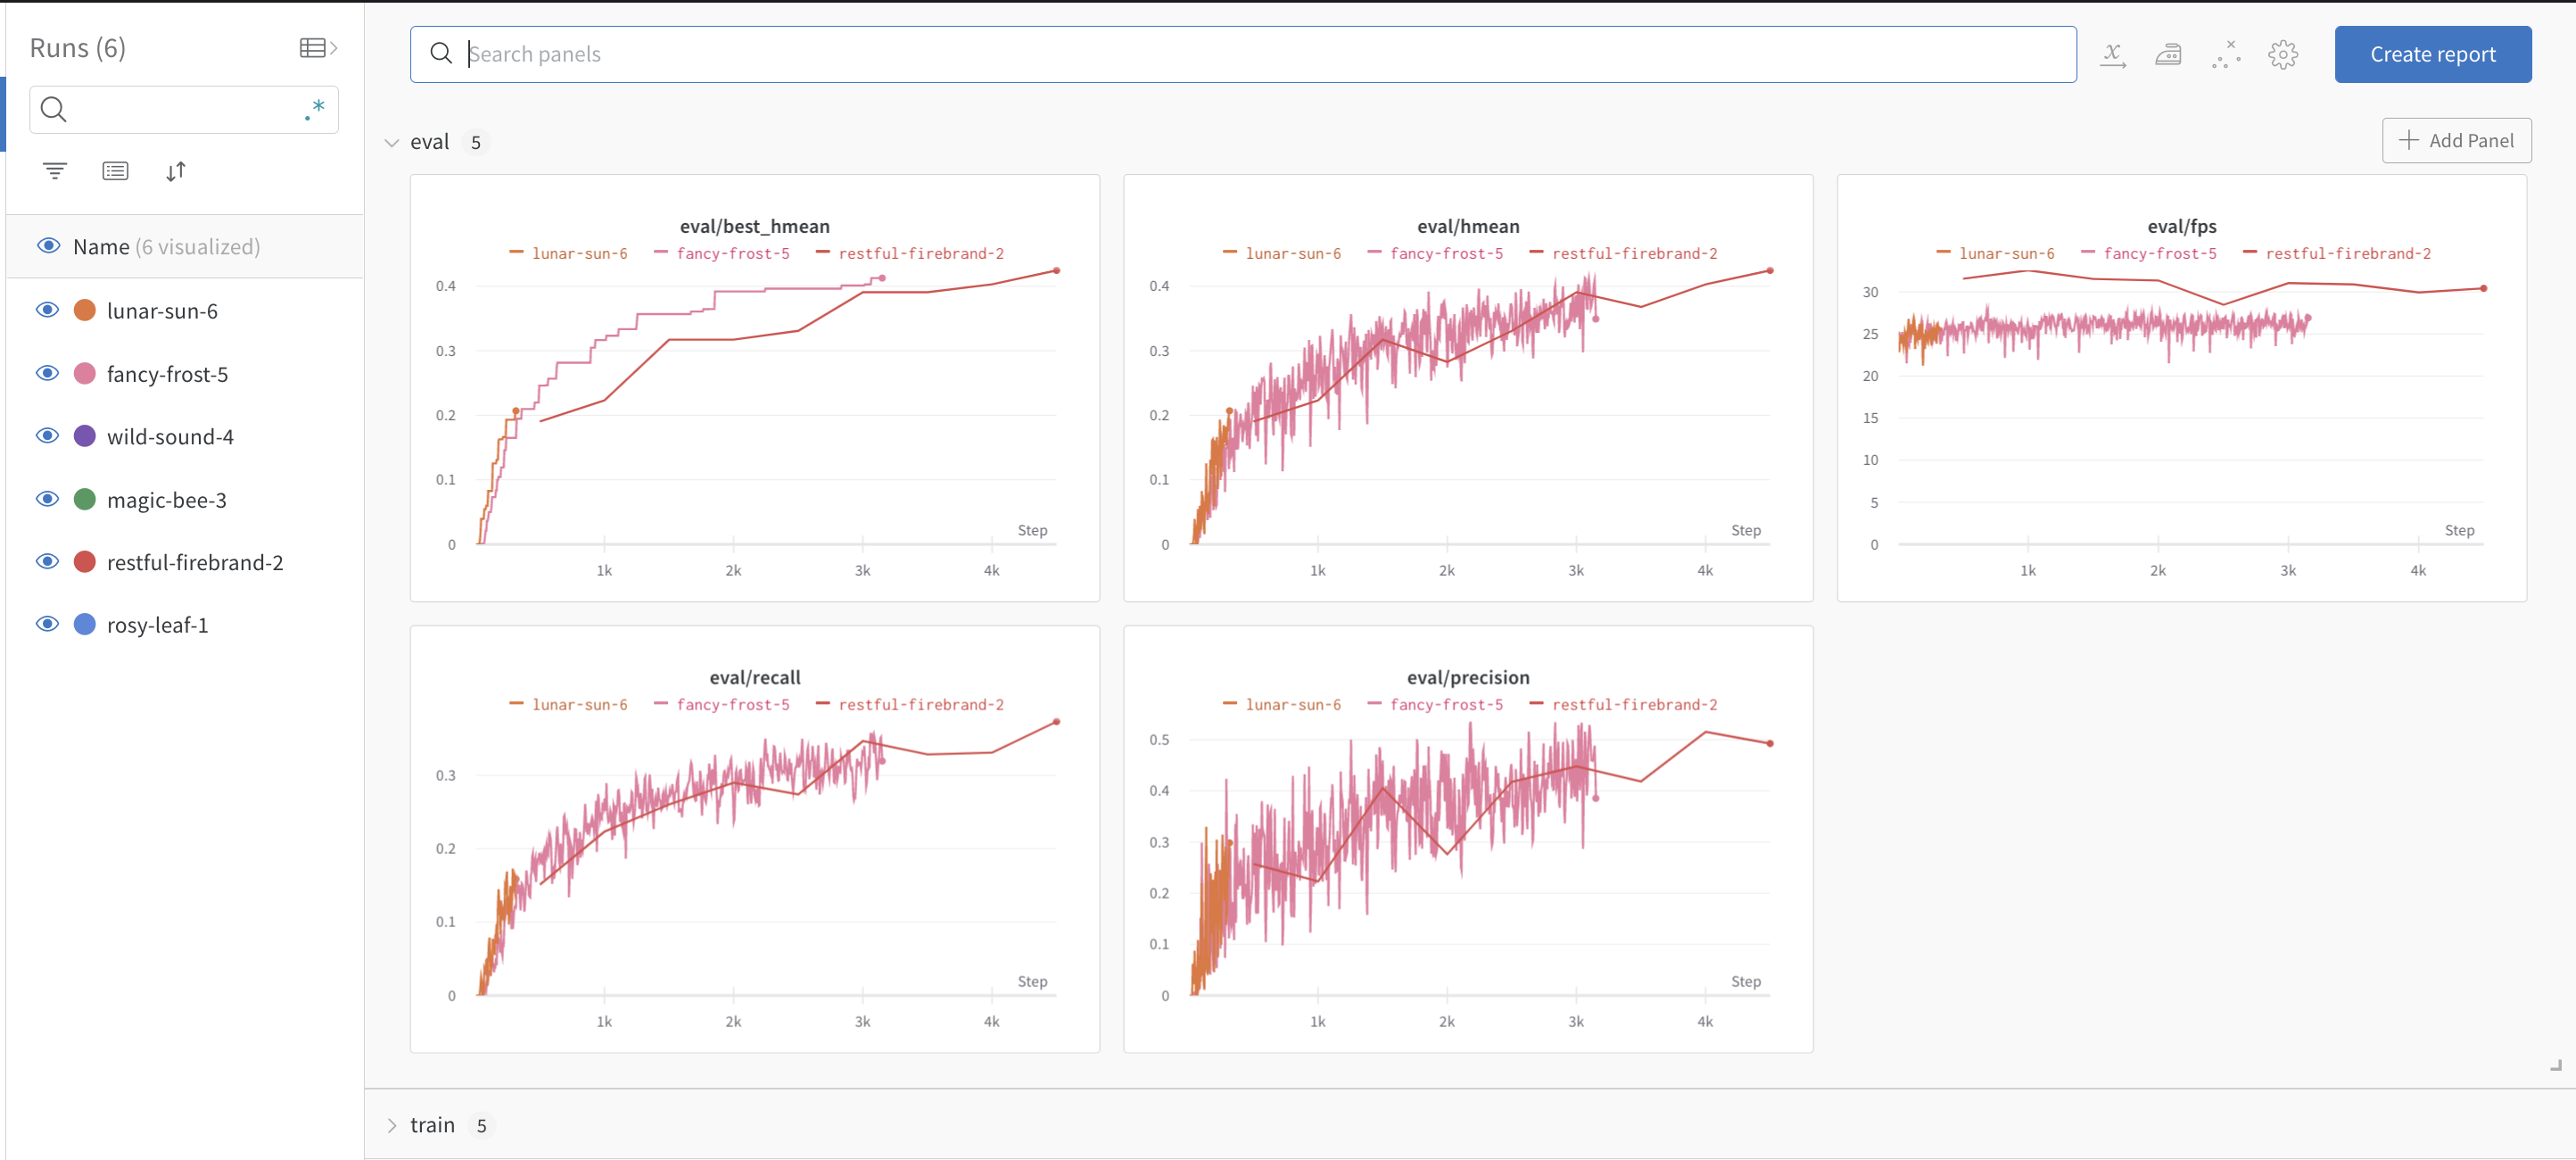